## Imports

In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

from astroplan import Observer
from astropy.table import Table
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

import math
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

# OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
# OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
OBJ_DATA_DIR = "/home/ramon/uanl/thesis/Backup Data"
ZTF_DATA_DIR = os.path.join(OBJ_DATA_DIR, "IRSA")

# CONCAT_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-phase-folded.csv")
# CONCAT_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-data.ecsv")

ITURBIDE_DATA = "/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat"

# AVILES_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide Aviles", "aviles-differential-flux.csv")
# AVILES_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide Aviles", "normalized-differential-flux.ecsv")

# GAIA_EPOCH_PHOTOMETRY_CSV = f"{OBJ_DATA_DIR}/Gaia Epoch Photometry - Indiv/EPOCH_PHOTOMETRY-Gaia DR3 1982536257931470464.csv"
GAIA_EPOCH_PHOTOMETRY_CSV = os.path.join(OBJ_DATA_DIR, "Gaia Epoch Photometry - Indiv", "DR3", "rel-norm-flux.ecsv")

## Object and Observatory Info

In [2]:
objCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
objCoord

<SkyCoord (ICRS): (ra, dec) in deg
    (339.94690379, 45.14639753)>

In [3]:
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
iturbideLocation

<EarthLocation (-996310.5451336, -5711351.68420869, 2655479.91503921) m>

## Iturbide observation data

In [4]:
rawIturbideData = Table.read(ITURBIDE_DATA, format='ascii').to_pandas()
rawIturbideData.columns = ['fname', 'filter', 'exptime', 'hjd', 'airmass', 
					  'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
					  'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7']
rawIturbideData = rawIturbideData[(rawIturbideData['err1'] < 1) & (rawIturbideData['err5'] < 90)] # removing most egregious data points
rawIturbideData

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006


In [5]:
# convert hjd -> bjd
iturbideHjdTime = Time(rawIturbideData['hjd'], scale='utc', format='jd')
heliocentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=iturbideLocation)
barycentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=iturbideLocation)

iturbideBjdTime = (iturbideHjdTime - heliocentricCorrection) + barycentricCorrection

# using TCB scale to be compatible with Gaia
rawIturbideData['bjd'] = iturbideBjdTime.tdb.value
rawIturbideData

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7,bjd
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006,2.459875e+06
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005,2.459875e+06
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005,2.459875e+06
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006,2.459875e+06
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006,2.459875e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006,2.459925e+06


In [6]:
iturbideObservations = pd.DataFrame()
iturbideObservations['bjd'] = rawIturbideData['bjd']
iturbideObservations['mag'] = rawIturbideData['mag1'] - rawIturbideData['mag5']
iturbideObservations['err'] = np.sqrt(np.power(rawIturbideData['err1'], 2) + np.power(rawIturbideData['err5'], 2))
iturbideObservations

,bjd,mag,err
0,2.459875e+06,1.2220,0.020616
1,2.459875e+06,1.1890,0.017464
2,2.459875e+06,1.2317,0.016553
3,2.459875e+06,1.1772,0.017464
4,2.459875e+06,1.1603,0.016553
...,...,...,...
1267,2.459925e+06,1.4668,0.021541
1268,2.459925e+06,1.4435,0.022472
1269,2.459925e+06,1.4819,0.027203
1270,2.459925e+06,1.5272,0.024352


In [7]:
QUARTER_PHASE_MAG = 1.1762 # taken from period analysis

# converting magnitudes to fluxes: https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476
iturbideObservations['norm_flux'] = 10**(-(2/5) * (iturbideObservations['mag'] - QUARTER_PHASE_MAG))

# formula taken from:
# https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does
	# might not be very accurate, since I haven't found the raw fluxes and am instead using normalized fluxes calculated above
iturbideObservations['norm_ferr'] = (iturbideObservations['norm_flux'] * iturbideObservations['err'] * math.log(10)) / 2.5
iturbideObservations

,bjd,mag,err,norm_flux,norm_ferr
0,2.459875e+06,1.2220,0.020616,0.958694,0.018203
1,2.459875e+06,1.1890,0.017464,0.988280,0.015897
2,2.459875e+06,1.2317,0.016553,0.950167,0.014486
3,2.459875e+06,1.1772,0.017464,0.999079,0.016070
4,2.459875e+06,1.1603,0.016553,1.014752,0.015471
...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,0.765174,0.015181
1268,2.459925e+06,1.4435,0.022472,0.781772,0.016181
1269,2.459925e+06,1.4819,0.027203,0.754606,0.018907
1270,2.459925e+06,1.5272,0.024352,0.723769,0.016233


## Gaia epoch photometry

In [8]:
from astropy.time import Time

# gaiaObservations = pd.read_csv(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = Table.read(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = gaiaObservations[(gaiaObservations['rejected_by_photometry'] == False) & (gaiaObservations['rejected_by_variability'] == False)]

# correcting units so that they're compatible with astropy
gaiaObservations['flux'] = gaiaObservations['flux'].value * u.electron*(u.second**(-1))
gaiaObservations['flux_error'] = gaiaObservations['flux_error'].value * u.electron*(u.second**(-1))

# maintaining tcb scale to avoid transforming to heliocentric
t = Time(gaiaObservations['time'] + 2455197.5, format='jd', scale='tcb')
gaiaObservations['jd'] = t.tdb.jd
gaiaObservations.to_pandas()

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,norm_flux,norm_ferr,jd
0,1982536257931470464,15914106402149388,G,1684.645069,16.809998,3555.883734,13.240487,268.561401,False,False,1,375316653866487564,1.657540,0.006172,2.456882e+06
1,1982536257931470464,15923847240881531,G,1684.821236,16.808627,3560.378122,11.872833,299.876038,False,False,1,375316653866487564,1.659635,0.005534,2.456882e+06
2,1982536257931470464,15927939542726427,G,1684.895246,16.925122,3198.144064,14.858678,215.237457,False,False,1,375316653866487564,1.490783,0.006926,2.456882e+06
3,1982536257931470464,15937680367558820,G,1685.071412,16.899170,3275.507705,64.642659,50.670994,False,False,4097,375316653866487564,1.526845,0.030133,2.456883e+06
4,1982536257931470464,15941772663767622,G,1685.145395,16.775474,3670.768815,13.205851,277.965332,False,False,4194305,375316653866487564,1.711092,0.006156,2.456883e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1982536257931470464,68564649765818840,RP,2636.797157,16.107843,2857.728742,34.570173,82.664581,False,False,0,375316653866487564,3.164652,0.038283,2.457834e+06
193,1982536257931470464,68574390600082284,RP,2636.973312,16.210664,2599.517311,29.385957,88.461212,False,False,0,375316653866487564,2.878709,0.032542,2.457834e+06
194,1982536257931470464,68578482921453413,RP,2637.047319,16.354475,2277.026942,38.569154,59.037514,False,False,0,375316653866487564,2.521582,0.042712,2.457835e+06
195,1982536257931470464,71504440274863554,RP,2689.962995,16.131512,2796.104174,30.633779,91.275200,False,False,0,375316653866487564,3.096409,0.033924,2.457887e+06


In [9]:
gaia_g  = gaiaObservations[gaiaObservations['band'] == 'G']
gaia_bp = gaiaObservations[gaiaObservations['band'] == 'BP']
gaia_rp = gaiaObservations[gaiaObservations['band'] == 'RP']

## PHOEBE bundle set-up

In [10]:
# b = phoebe.default_contact_binary()
b = phoebe.default_binary(semidetached=True) # trying out semi-detached binary

In [11]:
computePhases = phoebe.linspace(0, 1, 16)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True, ntriangles=5000)
print(b['mesh01'])

ParameterSet: 8 parameters
     compute_times@mesh01@dataset: [0.         0.06666667 0.13333333 ...
 0.86666667 0.93333333 1.        ] d
C   compute_phases@mesh01@dataset: [ 0.          0.06666667  0.13333333 ...
 -0.13333333 -0.06666667  0.        ]
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: ['teffs']
         enabled@phoebe01@compute: True
        compute_phases@constraint: times_to_phases({compute_times@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


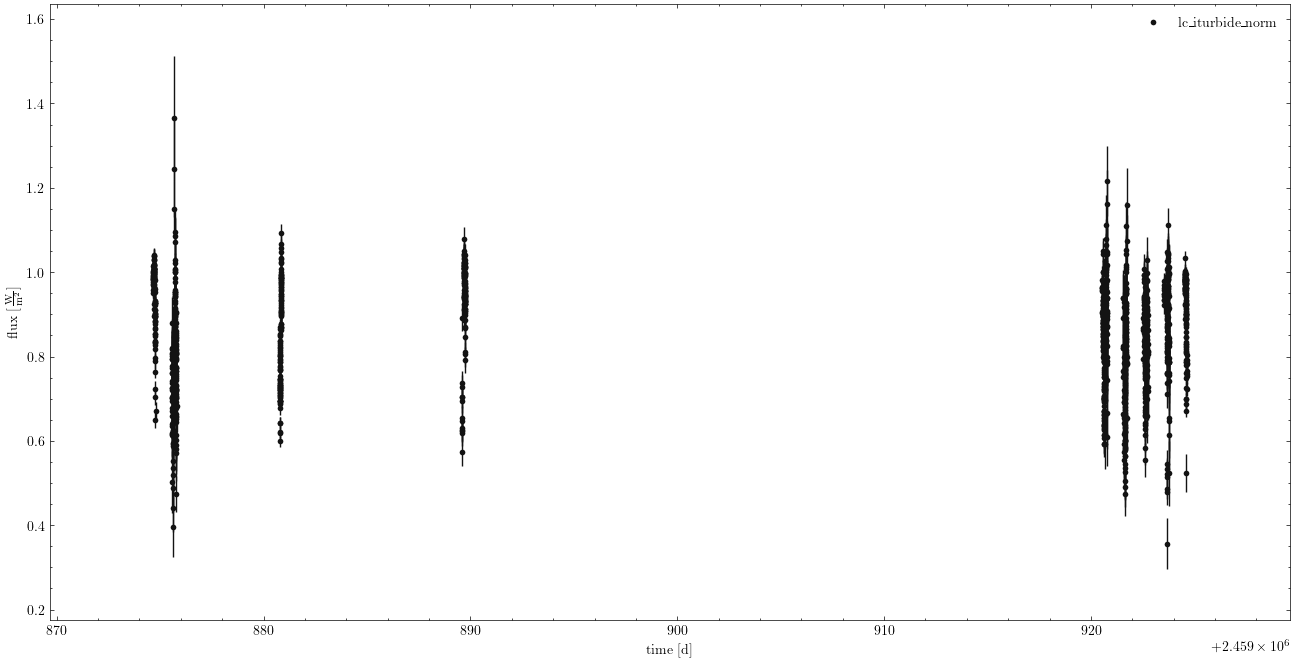

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [12]:
b.add_dataset('lc', dataset='lc_iturbide_norm', overwrite=True,
              times=iturbideObservations['bjd'].to_numpy(), 
              fluxes=iturbideObservations['norm_flux'].to_numpy(), 
			  sigmas=iturbideObservations['norm_ferr'].to_numpy())
# b.add_dataset('lc', dataset='lc_iturbide_raw', overwrite=True,
#               times=iturbideObservations['hjd'].jd, 
#               fluxes=iturbideObservations['raw_flux'], 
# 			  sigmas=iturbideObservations['ferr'])

# b.add_dataset('lc', dataset='lc_iturbide_aviles_norm', overwrite=True,
#               times=avilesObservations['time'].jd, 
#               fluxes=avilesObservations['norm_flux'])
# b.add_dataset('lc', dataset='lc_iturbide_aviles_raw', overwrite=True,
#               times=avilesObservations['time'].jd, 
#               fluxes=avilesObservations['flux'])

fig = plt.figure(figsize=(16,8))
b.plot(dataset='lc_iturbide_norm', show=True, marker='.', s=0.008, legend=True, fig=fig)
# b.plot(dataset='lc_iturbide_raw', show=True, marker='.', legend=True)

# b.plot(dataset='lc_iturbide_aviles_norm', show=True, marker='.', legend=True)
# b.plot(dataset='lc_iturbide_aviles_raw', show=True, marker='.', legend=True)

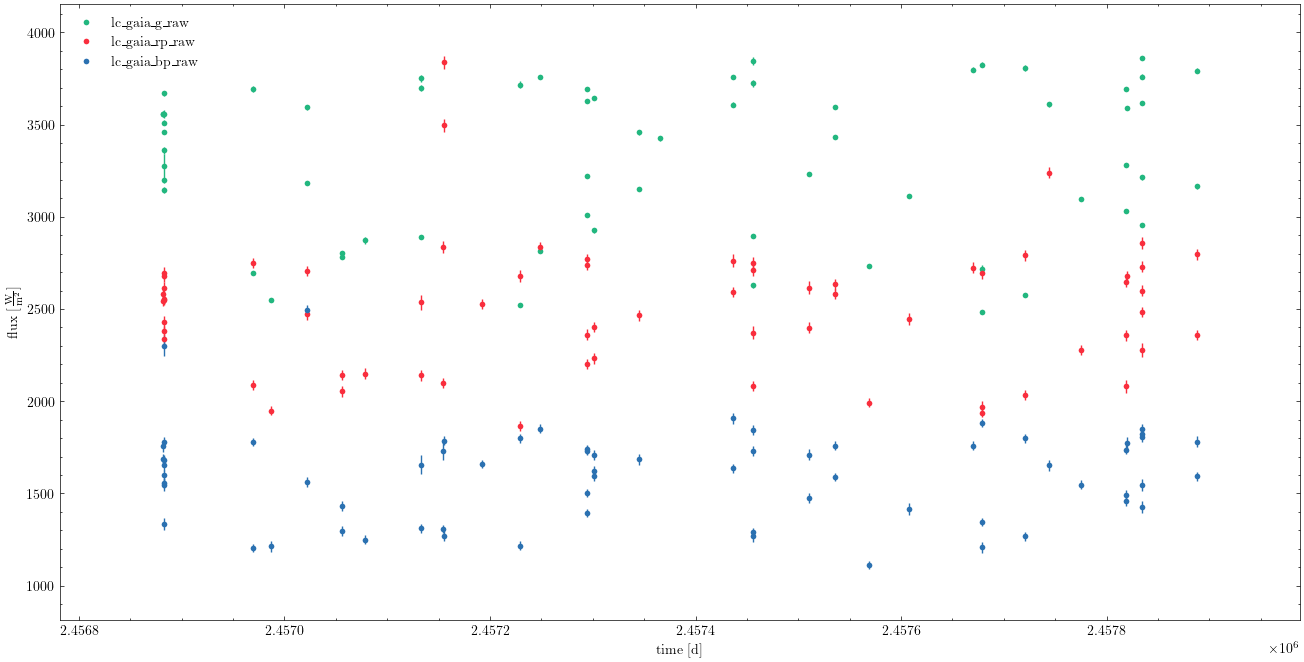

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [13]:
# b.add_dataset('lc', 
#               times=gaia_g['jdTime'], fluxes=gaia_g['norm_flux'], sigmas=gaia_g['norm_ferr'], 
#               passband='Gaia:G', dataset='lc_gaia_g_norm', overwrite=True)
# b.add_dataset('lc', 
#               times=gaia_rp['jdTime'], fluxes=gaia_rp['norm_flux'], sigmas=gaia_rp['norm_ferr'], 
#               passband='Gaia:RP', dataset='lc_gaia_rp_norm', overwrite=True)
# b.add_dataset('lc', 
#               times=gaia_bp['jdTime'], fluxes=gaia_bp['norm_flux'], sigmas=gaia_bp['norm_ferr'], 
#               passband='Gaia:BP', dataset='lc_gaia_bp_norm', overwrite=True)

# TODO: try to figure out why units are messing up
    # electron/s from gaia, PHOEBE expects W/s
# ignoring units for now as work-around
b.add_dataset('lc', 
              times=gaia_g['jd'], fluxes=gaia_g['flux'].value, sigmas=gaia_g['flux_error'].value,
              passband='Gaia:G', dataset='lc_gaia_g_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jd'], fluxes=gaia_rp['flux'].value, sigmas=gaia_rp['flux_error'].value,
              passband='Gaia:RP', dataset='lc_gaia_rp_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jd'], fluxes=gaia_bp['flux'].value, sigmas=gaia_bp['flux_error'].value,
              passband='Gaia:BP', dataset='lc_gaia_bp_raw', overwrite=True)

# b.plot(kind='lc', dataset=['lc_gaia_g_norm', 'lc_gaia_bp_norm', 'lc_gaia_rp_norm'], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)

fig = plt.figure(figsize=(16, 8))
b.plot(kind='lc', dataset=['lc_gaia_g_raw', 'lc_gaia_bp_raw', 'lc_gaia_rp_raw'], show=True, legend=True, marker='.', s=0.008, color=gen_utils.GAIA_RAW_PLOT_COLORS, fig=fig)

## ZTF Data

Data retrieved using IRSA tools. Observations in `zg` and `zr` bands.

In [14]:
ztfPalomarLocation = EarthLocation.of_site("Palomar")
ztfPalomarLocation

<EarthLocation (-2410346.78217658, -4758666.82504051, 3487942.97502457) m>

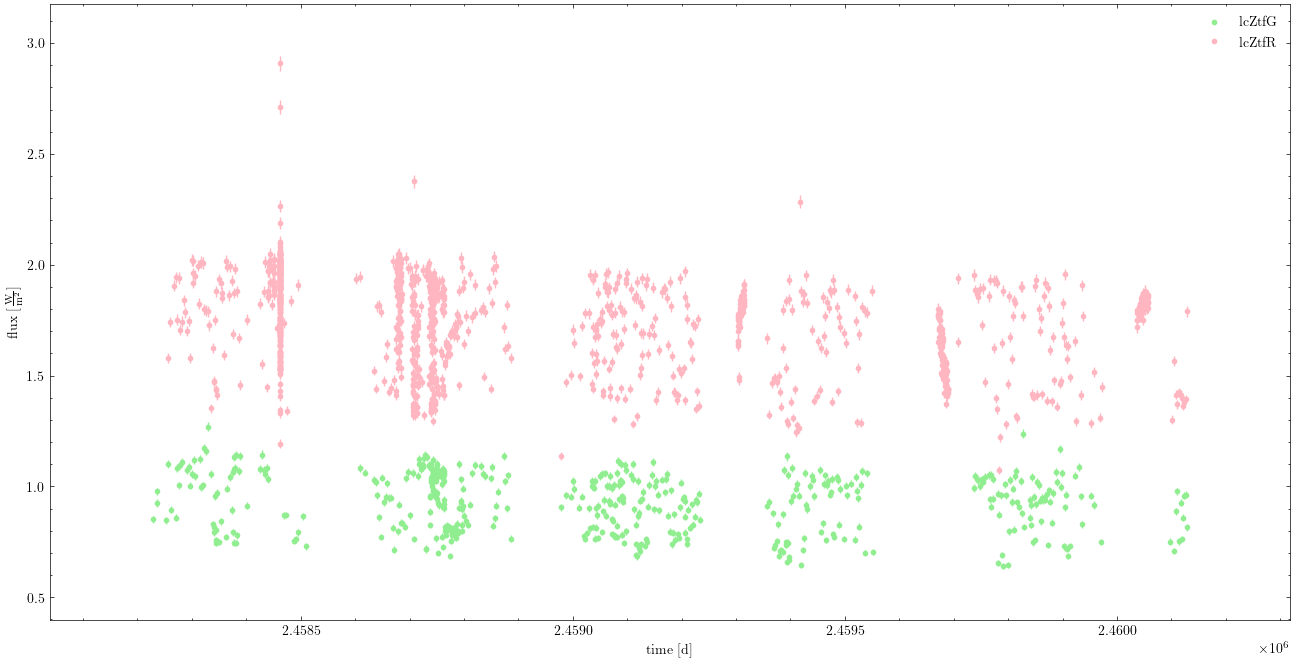

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [15]:
# for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["zg-flux.ecsv", "zr-flux.ecsv"]):
for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["rel-zg-flux.ecsv", "rel-zr-flux.ecsv"]):
	data = Table.read(os.path.join(ZTF_DATA_DIR, f))
	ztfHjdTime = Time(data['hjd'], scale='utc', format='jd')
	heliocentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=ztfPalomarLocation)
	barycentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=ztfPalomarLocation)

	ztfBjdTime = (ztfHjdTime - heliocentricCorrection) + barycentricCorrection
	b.add_dataset('lc', 
			   times=ztfBjdTime.tdb.value, fluxes=data['flux'], sigmas=data['fluxerr'],
			   passband=passband, dataset=f'lcZtf{nameSuffix}', overwrite=True)
	
fig = plt.figure(figsize=(16, 8))
b.plot(dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.008, show=True, fig=fig)

## Orbital Period

Setting orbital period to that determined using IRSA periodogram; very slight difference to period obtained from PHOEBE periodogram, but results in noticably
better fit.

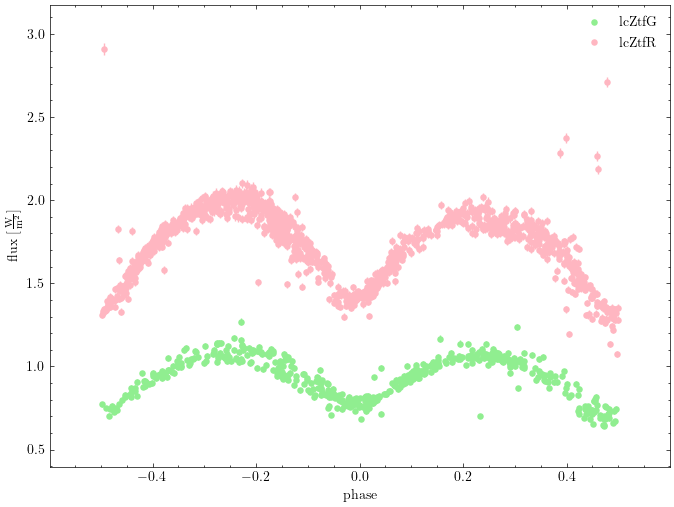

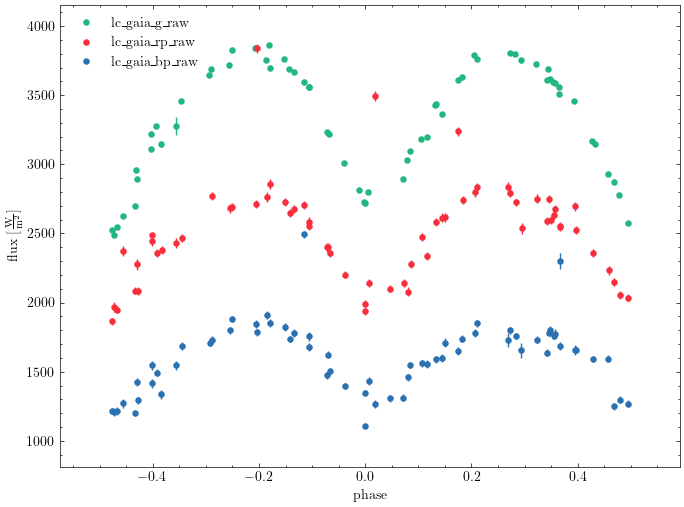

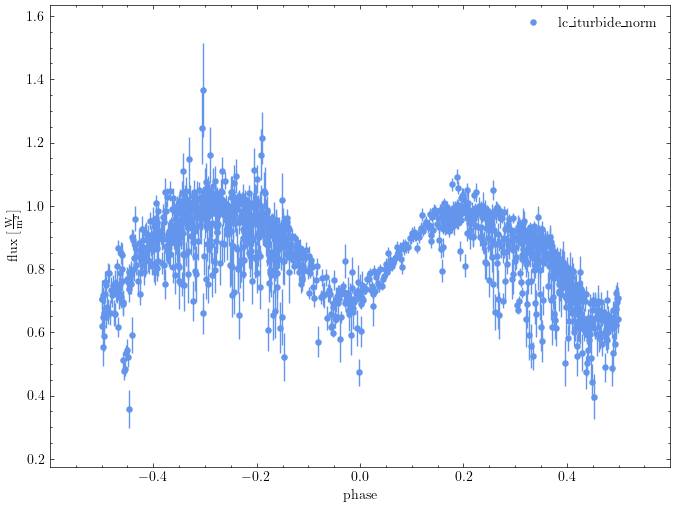

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [16]:
ZTF_PERIOD = 0.333566999 * u.day # obtained from IRSA periodogram
b.set_value(qualifier='period', component='binary', value=ZTF_PERIOD)

# TODO: remove
b.set_value(qualifier='t0_supconj', value=-0.037542756559644994 * u.day)

# ZTF
b.plot(x='phase', dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.015, show=True)

# Gaia
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]
b.plot(x='phase', dataset=rawGaiaDatasets, marker='.', legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS, s=0.015, show=True)
# normGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'norm' in d]
# b.plot(x='phase', dataset=normGaiaDatasets, marker='.', legend=True, color=gen_utils.GAIA_NORM_PLOT_COLORS, s=0.015, show=True)

# Iturbide
b.plot(x='phase', dataset='lc_iturbide_norm', marker='.', legend=True, s=0.015, color=gen_utils.ITURBIDE_PLOT_COLORS, show=True)
# b.plot(x='phase', dataset='lc_iturbide_raw', marker='.', legend=True, s=0.015, show=True)
# b.plot(x='phase', dataset='lc_iturbide_aviles_norm', marker='.', legend=True, s=0.015, show=True)
# b.plot(x='phase', dataset='lc_iturbide_aviles_raw', marker='.', legend=True, s=0.015, show=True)

## Poro et al. (2021) Priors

In [17]:
b.flip_constraint(qualifier='mass', component='primary', solve_for="sma@binary")

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 5.299999999999999 solRad>

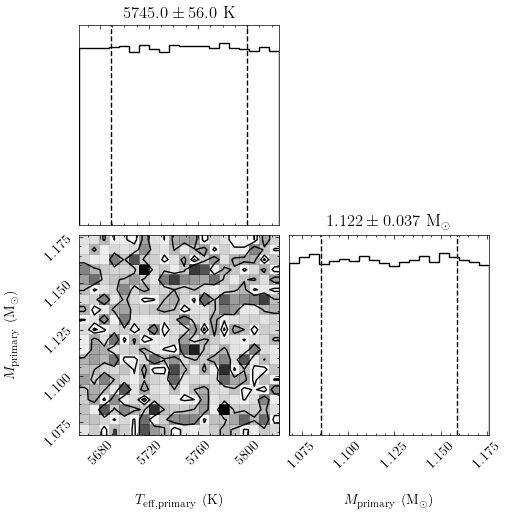

In [18]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Save bundle

In [19]:
# gen_utils.saveBundle(b, "iturbide_gaia-data")
# gen_utils.saveBundle(b, "iturbide_gaia-data", "aviles-data")
# gen_utils.saveBundle(b, "iturbide_gaia-data", "comp-LID-3")
# gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf")
# gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf", subfolder="ltt-corrected")
# gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf")
gen_utils.saveBundle(b, "semidetached-model")

# next: run periodogram

Thu, 06 Jun 2024 01:55 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/semidetached-model.json.gz'